# TP3 : Gain et impact de marché

Ethan Trentin, Alexandre Boistard

## Introduction

Ce troisième travail pratique s’inscrit dans la continuité de l’étude des 
dynamiques de marché à travers des modèles d'agents. L’objectif principal 
est d’analyser les gains obtenus par différentes catégories d’investisseurs,
ainsi que d'étudier l’impact que leurs décisions peuvent avoir sur le 
marché lui-même.

Nous nous appuierons pour cela sur le **jeu de la minorité** à nombre 
variable de spéculateurs, tel que développé dans le TP3.1. Cette version 
modifiée permettra de simuler des comportements plus réalistes et de mesurer
les effets d’interactions stratégiques entre agents.

## Objectifs

1. Étudier le gain de différentes catégories d’investisseurs.
2. Étudier l’impact de l’impact (effet retour) sur le comportement des agents.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit

### 0/ Reprise des briques élémentaires du tp 3.1

In [138]:
# Dans un premier temps, crééons une fonction permettant d'initialiser les stratégies.

def initialize(Ns, P, Np):
    """La fonction initialize prend trois arguments :
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : les autres agents
    On retourne la matrice strategies, la matrice performance, ainsi que le vecteur Omega et le nombre mu."""

    # On initialise les agents avec des stratégies aléatoires entre -1 et 1
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    # On initialise les performances à 0
    performance = np.zeros(Ns)

    # On initialise omega et mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # On veut générer un nombre entre 0 et P-1 inclus
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

# Maintenant, on définit une fonction pour créer une simulation du jeu, qui va faire appel à la fonction simulation.

def simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne le vecteur A_history qui représente l'historique des actions au cours du temps, mu_history qui représente le vecteur des états au cours du temps, et la performance des agents qui est un vecteur."""

    # On passe en argument la fonction d'initialisation, en gardant en mémoire le fait qu'à la question 5 nous devrons utiliser une nouvelle initialisation des stratégies.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history = []
    mu_history = []
    
    n_list = []
    payoff_list= []
    for t in range(T):
        # On récupère les actions des stratégies pour l'état mu
        a_mu_t = strategies[:, mu]

        # On détermine les actions des agents en fonction de leur performance à l'aide d'une fonction de Heaviside.
        n_i = (performance >= 0) * 1
        n_list.append(n_i)
        # On calcule l'action A(t) en utilisant la somme des actions des agents et le vecteur Omega
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        # On rajoute la valeur des actions à l'instant t à l'historique
        A_history.append(A_t)
            
        # On met à jour la performance
        performance += -a_mu_t * A_t - epsilon
        payoff_list.append(performance+epsilon)
        # On met à jour la valeur de mu : on a deux méthodes disponibles (mettre à jour aléatoirement comme à l'initialisation ou mettre à jour en utilisantt les M derniers signes de A(t), mais nous allons choisir la première méthode puisque la deuxième ne nous donnait pas toujours des résultats cohérents)
        # sign = A_t > 0
        # mu = (2*mu)%2**M + sign
        mu = np.random.randint(0, P)
        mu_history.append(mu)

    return A_history, mu_history, performance, n_list, payoff_list

# Une fois qu'on a l'initialisation et la simulation, nous pouvons créer une fonction permettant d'afficher le résultat graphique de la simulation.

def plot_simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction plot_simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On affiche le graphique de A(t) au cours du temps."""

    # On récupère l'historique des actions grâce à la fonction simulation.
    A_history, _, _, _,_ = simulation(initialization, Ns, P, Np, M, T, epsilon)
    plt.figure(figsize=(10, 5))
    plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    plt.xlabel('Temps')
    plt.ylabel('A(t)')
    plt.title('Simulation de A(t) au cours du temps')
    plt.legend()
    plt.grid()
    plt.show()

In [139]:
# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 150000 # L'horizon temporel
Ns = 16*5 # Le nombre de spéculateurs
epsilon = 0.05 # La performance minimale pour continuer de participer au jeu

In [140]:
# On va afficher A_history qui est une série temporelle des actions A(t), mu_history qui représente l'historique des états and les 5 agents les plus performants.
A_history, mu_history, performance, _, _ = simulation(initialize, Ns, P, Np, 
                                                     M, T,
                                                 epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print(performance)
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 8
Final A(t): 1.271959095995903
[-1.37129498e+04 -2.45850378e+03 -6.63754661e+03 -2.74399752e+04
 -1.82070798e+00 -9.57712868e+03 -3.14076445e+03 -8.69684774e+03
 -2.37745194e+04 -2.10251820e+00 -1.81903288e+04 -1.32334523e+03
  4.96197975e+03 -4.28090340e+03 -8.89307782e+00  1.25252599e+02
 -8.26398534e+03  8.05621424e+03 -5.75198267e-01 -4.78397914e+03
 -8.13390094e+03 -1.00433678e+04 -6.79700245e+03 -4.21123624e+01
  4.39481681e-01 -1.27299634e+03 -6.05155365e+00 -1.03527591e+04
 -3.80658170e+01 -2.03555010e+04 -9.26606453e+03 -2.20071989e+04
 -5.62298260e+03 -1.40224944e+04 -4.12666501e+00 -1.24098282e+04
 -1.04883552e+04  8.65045979e+03 -8.21243631e+03 -4.38775225e+03
 -6.55178055e+03 -2.11056048e+04 -4.46605229e+03 -1.08795475e+04
 -1.34417828e+04 -2.09476193e+03  6.58453852e+03 -1.54026480e+03
 -1.53014413e+04 -1.92201226e+03 -1.27186942e+04 -1.64770473e+03
 -7.72133537e+03 -1.03402745e+04 -1.08049412e+04 -5.50808673e+03
 -1.14476090e+04 -1.15337520e+04 -6.13576516e+00

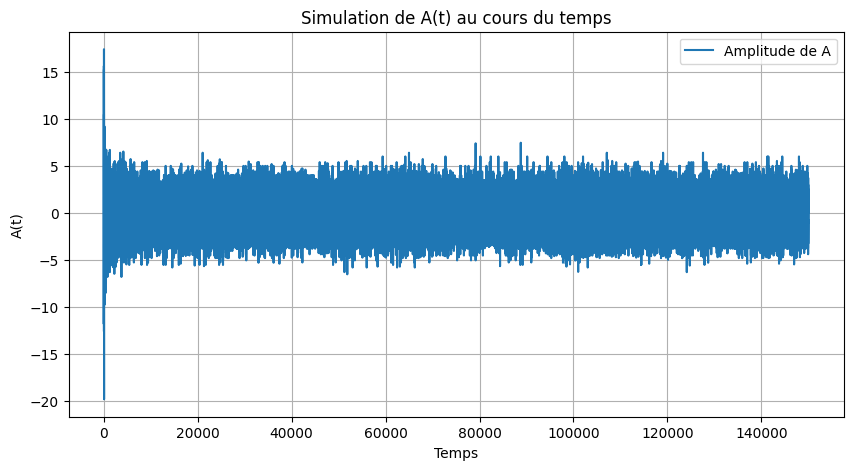

In [123]:
# Déjà, nous allons afficher la simulation pour les paramètres précédents définis.
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

### 1/ Fréquence de jeu et impact

In [141]:
##calcul de la fréquence de jeu

def compute_playing_frequency(n_list, performances):
    """La fonction compute_playing_frequency prend trois arguments :
    On retourne la fréquence de jeu."""
    
    # On initialise la matrice de fréquence de jeu
    freq = [0 for _ in range(len(n_list[0]))]
    avg_gain = [0 for _ in range(len(n_list[0]))]
    # On parcourt les agents
    for i in range(len(n_list)):
        # On parcourt les agents
        freq += n_list[i]
        avg_gain += performances[i]
    freq=freq / len(n_list)
    avg_gain=avg_gain / len(n_list)
    return freq, avg_gain

In [142]:
# On va calculer la fréquence de jeu pour les paramètres précédents définis.
A_history, mu_history, performance, n_list, performance_list = simulation(initialize, Ns,P, Np, M, T, epsilon)

t_stationnaire = 20000
freq, gain = compute_playing_frequency(n_list[t_stationnaire:], performance_list[t_stationnaire:])

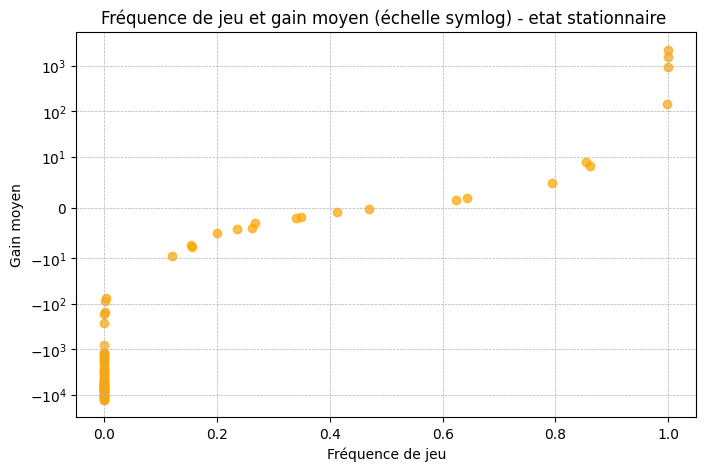

In [143]:
plt.figure(figsize=(8, 5))
plt.scatter(freq, gain, color='orange', alpha=0.7)
plt.yscale("symlog", linthresh=10)  # linthresh définit la zone centrale linéaire autour de 0
plt.xlabel("Fréquence de jeu")
plt.ylabel("Gain moyen")
plt.title("Fréquence de jeu et gain moyen (échelle symlog) - etat "
          "stationnaire ")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Commentaires : les agents qui jouent peu sont ceux dont la stratégie est 
perdante, ils arretent donc de jouer par la suite. Ceux dont la stratégie 
exploite bien la prévisibilité du marché sont capable de jouer davantage 
voire presque toute le temps, et leur gain moyen est positif. 

### 2/ Impact de la stratégie sur le gain

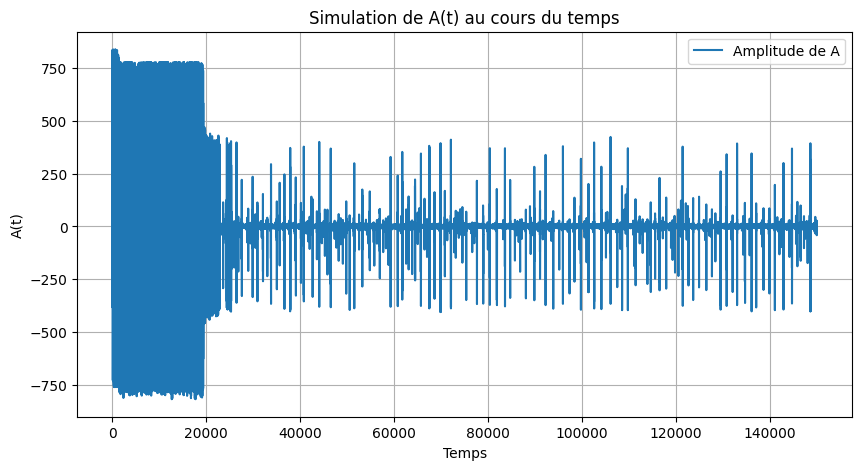

In [120]:
## on choisit des paramètres pour un A(t) instable

# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 150000 # L'horizon temporel
Ns = P*100 # Le nombre de spéculateurs
epsilon = 0.01 # La performance minimale pour continuer de participer au jeu

# Déjà, nous allons afficher la simulation pour les paramètres précédents définis.
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

In [128]:
def random_binary_list(n, ro):
    """
    Crée une liste binaire aléatoire de taille n avec une proportion ro de 1.
    ro ∈ [0,1] est la fréquence de 1 attendue.
    """
    ro = min(max(ro, 0), 1)  # clamp dans [0, 1]
    k = int(ro * n)
    arr = np.array([1]*k + [0]*(n - k))
    np.random.shuffle(arr)
    return arr

In [153]:
#2 impact et gain question 2

# Dans un premier temps, crééons une fonction permettant d'initialiser les stratégies.

def simulation_ro(initialization, Ns, P, Np, M, T, epsilon, ro=0.2):
    """La fonction simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne le vecteur A_history qui représente l'historique des actions au cours du temps, mu_history qui représente le vecteur des états au cours du temps, et la performance des agents qui est un vecteur."""

    # On passe en argument la fonction d'initialisation, en gardant en mémoire le fait qu'à la question 5 nous devrons utiliser une nouvelle initialisation des stratégies.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history = []
    mu_history = []
    ro_test = random_binary_list(Ns, ro)
    kappa_test = np.random.uniform(0.001, 0.01, size=Ns) * ro_test
    n_list = []
    payoff_list= []
    for t in range(T):
        # On récupère les actions des stratégies pour l'état mu
        a_mu_t = strategies[:, mu]

        # On détermine les actions des agents en fonction de leur performance à l'aide d'une fonction de Heaviside.
        n_i = (performance >= 0) * 1
        n_list.append(n_i)
        # On calcule l'action A(t) en utilisant la somme des actions des agents et le vecteur Omega
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        # On rajoute la valeur des actions à l'instant t à l'historique
        A_history.append(A_t)
            
        # On met à jour la performance
        payoff = -a_mu_t * A_t
        performance += payoff - epsilon - kappa_test * (1-n_i)
        payoff_list.append(payoff)
        # On met à jour la valeur de mu : on a deux méthodes disponibles (mettre à jour aléatoirement comme à l'initialisation ou mettre à jour en utilisant les M derniers signes de A(t), mais nous allons choisir la première méthode puisque la deuxième ne nous donnait pas toujours des résultats cohérents)
        # sign = A_t > 0
        # mu = (2*mu)%2**M + sign
        mu = np.random.randint(0, P)
        mu_history.append(mu)

    return A_history, mu_history, performance, n_list, payoff_list, kappa_test



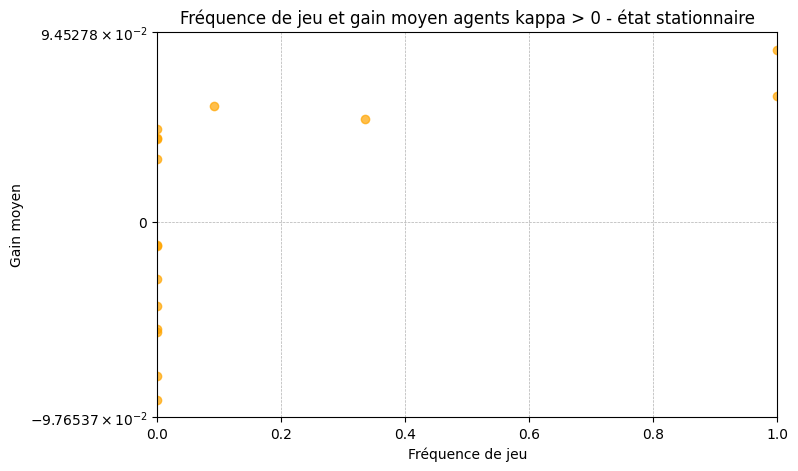

In [154]:
A_history, mu_history, performance, n_list, performance_list, kappa_test = (
    simulation_ro(
    initialize, Ns, P, Np, M, T, epsilon))


# On extrait les lignes correspondantes avec un masque numpy
n_filtered = np.array(n_list)[:,kappa_test > 0]
perf_filtered = np.array(performance_list)[:,kappa_test >0] 

# Ensuite on coupe pour ne prendre que la partie stationnaire
t_stationnaire = 30000
n_plot = n_filtered[t_stationnaire:]
perf_plot = perf_filtered[t_stationnaire:] 

# Calcul fréquence et gain
freq, gain = compute_playing_frequency(n_plot, perf_plot)

# Affichage
plt.figure(figsize=(8, 5))
plt.scatter(freq, gain, color='orange', alpha=0.7)
plt.yscale("symlog", linthresh=10)
plt.xlabel("Fréquence de jeu")
plt.ylabel("Gain moyen")
plt.xlim(0, 1)
plt.title("Fréquence de jeu et gain moyen agents kappa > 0 - état stationnaire")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Comments : certains agent ont une stratégie avec gain moyen négatif, ils ne 
jouent pas. Ceux dont qui ont une stratégie avec de la prévisibilité jouent 
si leur impact est inférieur à kappa_i, mais certains dont le gain moyen est 
positif arretent de jouer si leur impact est trop important.